# Jane Street - NN

In [1]:
import joblib
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, PrecisionAtRecall
from tensorflow.keras.optimizers import Adam, SGD

# set tensorflow's random seed
tf.random.set_seed(13)

In [2]:
# read data as 32 bit floats
file = os.path.join(os.pardir, "input", "jane-street-market-prediction", "train.csv")
dtype = {c: np.float32 for c in pd.read_csv(file, nrows=1).columns}
full_df = pd.read_csv(file, engine="c", dtype=dtype)

In [3]:
# split into training and validation
train_df = full_df[full_df["date"].between(0, 400)]
valid_df = full_df[full_df["date"].between(425, 500)]

# fill missing values with mean
#mean = train_df.mean()
#train_df = train_df.fillna(mean)
#valid_df = valid_df.fillna(mean)

# store imputation values
# mean.to_csv("impute.csv")

# build features and labels
features = [f"feature_{x}" for x in range(130)]
train_X = train_df[features].to_numpy()
valid_X = valid_df[features].to_numpy()
train_y = train_df["resp"].gt(0.0).astype(np.float32).to_numpy()
valid_y = valid_df["resp"].gt(0.0).astype(np.float32).to_numpy()

print(f"Class imbalance: {train_y.mean()}")

Class imbalance: 0.5060208439826965


In [ ]:
pp = SimpleImputer(strategy="mean")

train_X = pp.fit_transform(train_X)
valid_X = pp.transform(valid_X)

In [4]:
# model training parameters
BATCH_SIZE = 512
LEARNING_RATE = 1e-3
EPOCHS = 200

# show precision at this recall in metrics
METRIC_RECALL = 0.55

In [5]:
# input & normalization
norm = layers.experimental.preprocessing.Normalization()
norm.adapt(train_X)
inputs = layers.Input(shape=[len(features)])
flow = norm(inputs)

# Gaussian noise
# flow = layers.GaussianNoise(stddev=0.05)(flow)

# dense logic
flow = layers.Dense(units=40)(flow)
flow = layers.Activation(keras.activations.swish)(flow)
flow = layers.Dropout(rate=0.5)(flow)

flow = layers.Dense(units=1)(flow)
outputs = layers.Activation("sigmoid")(flow)

# optimization parameters
loss = BinaryCrossentropy()
optimizer = Adam(learning_rate=LEARNING_RATE)
metrics = [PrecisionAtRecall(recall=METRIC_RECALL, name="p@r"), AUC(name="auc")]

# compile the model and print a summary
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130)]             0         
_________________________________________________________________
normalization (Normalization (None, 130)               261       
_________________________________________________________________
dense (Dense)                (None, 40)                5240      
_________________________________________________________________
activation (Activation)      (None, 40)                0         
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0     

In [6]:
# define callback for early stopping
stopping = EarlyStopping(monitor="val_loss",
                         patience=10,
                         min_delta=1e-5,
                         restore_best_weights=True)

# fit the model
hist = model.fit(train_X, train_y,
                 epochs=EPOCHS,
                 batch_size=BATCH_SIZE,
                 validation_data=(valid_X, valid_y),
                 callbacks=[stopping])

Epoch 1/200
3677/3677 [==============================] - 20s 5ms/step - loss: 0.7035 - p@r: 0.5162 - auc: 0.5176 - val_loss: 0.6922 - val_p@r: 0.5122 - val_auc: 0.5219
Epoch 2/200
3677/3677 [==============================] - 18s 5ms/step - loss: 0.6914 - p@r: 0.5238 - auc: 0.5307 - val_loss: 0.6921 - val_p@r: 0.5111 - val_auc: 0.5226
Epoch 3/200
3677/3677 [==============================] - 17s 5ms/step - loss: 0.6912 - p@r: 0.5251 - auc: 0.5324 - val_loss: 0.6920 - val_p@r: 0.5136 - val_auc: 0.5257
Epoch 4/200
3677/3677 [==============================] - 18s 5ms/step - loss: 0.6911 - p@r: 0.5256 - auc: 0.5331 - val_loss: 0.6914 - val_p@r: 0.5172 - val_auc: 0.5296
Epoch 5/200
3677/3677 [==============================] - 17s 5ms/step - loss: 0.6908 - p@r: 0.5273 - auc: 0.5352 - val_loss: 0.6917 - val_p@r: 0.5152 - val_auc: 0.5290
Epoch 6/200
3677/3677 [==============================] - 18s 5ms/step - loss: 0.6907 - p@r: 0.5275 - auc: 0.5361 - val_loss: 0.6917 - val_p@r: 0.5176 - val_auc:

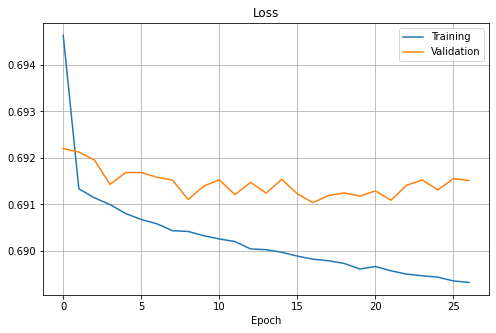

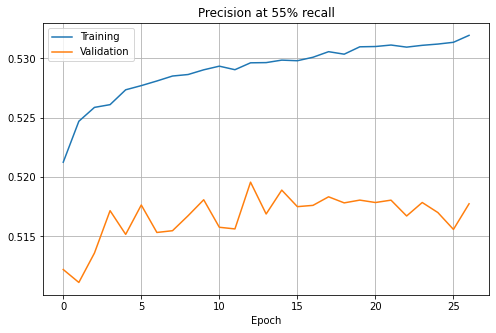

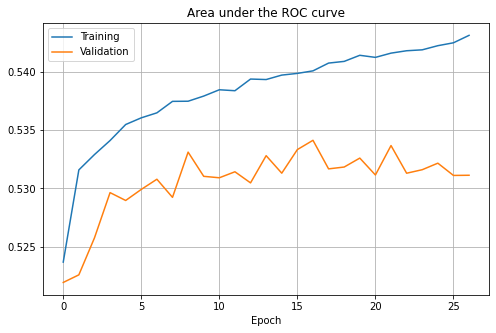

In [7]:
hist_df = pd.DataFrame(hist.history)

# loss
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["loss"], label="Training")
sns.lineplot(data=hist_df["val_loss"], label="Validation")
plt.title("Loss")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

# precision at recall
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["p@r"], label="Training")
sns.lineplot(data=hist_df["val_p@r"], label="Validation")
plt.title(f"Precision at {int(100 * METRIC_RECALL)}% recall")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

# area under ROC curve
plt.figure(figsize=(8, 5))
sns.lineplot(data=hist_df["auc"], label="Training")
sns.lineplot(data=hist_df["val_auc"], label="Validation")
plt.title("Area under the ROC curve")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("")
plt.show()

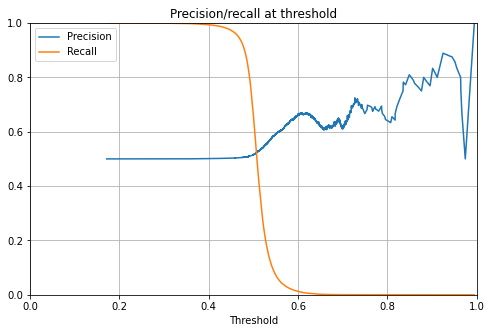

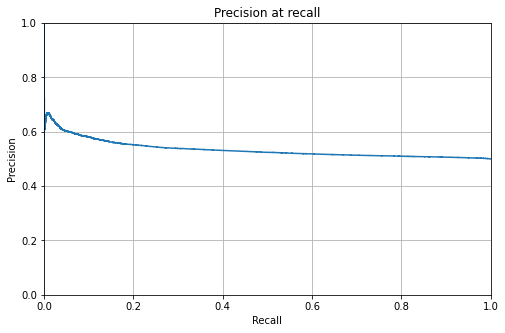

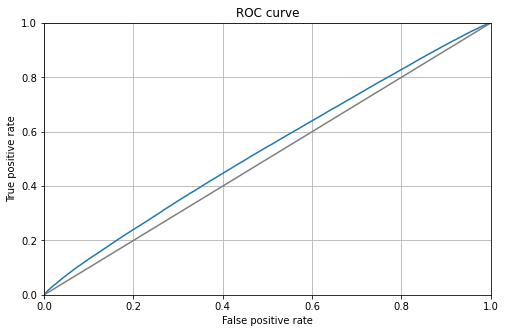

Final AUC: 0.5342306838030212


In [8]:
probs = model.predict(valid_X)

# precision vs recall
precisions, recalls, thresholds = precision_recall_curve(valid_y, probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "tab:blue", label="Precision")
plt.plot(thresholds, recalls[:-1], "tab:orange", label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.title("Precision/recall at threshold")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, "tab:blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision at recall")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# ROC curve
false_positives, true_positives, thresholds = roc_curve(valid_y, probs)
plt.figure(figsize=(8, 5))
plt.plot(false_positives, true_positives, "tab:blue")
plt.plot([0, 1], [0, 1], "tab:gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# AUC
print(f"Final AUC: {roc_auc_score(valid_y, probs)}")

In [9]:
joblib.dump(pp, "preprocessor.pkl")

with open("model.json", "w") as f:
    f.write(model.to_json())

model.save_weights("model.h5")